In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

In [2]:
# Create the CartPole environment
env = gym.make('CartPole-v1')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Old code



In [20]:
import numpy as np
import gym
import matplotlib.pyplot as plt

In [2]:
# Create the CartPole environment
env = gym.make('CartPole-v1')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
# Define hyperparameters
num_episodes = 1000
learning_rate = 0.01
gamma = 0.99

In [4]:
# Initialize the policy parameters
theta = np.random.randn(4, 2)

In [5]:
# Function to choose an action based on the state and policy
def get_action(state, theta):
    logits = np.dot(state, theta)
    probs = np.exp(logits) / np.sum(np.exp(logits))
    action = np.random.choice(env.action_space.n, p=probs)
    return action

In [6]:
# Function to compute the gradient of the policy
def compute_gradient(episode, theta):
    gradient = np.zeros_like(theta)
    for t, (state, action, reward) in enumerate(episode):
        logits = np.dot(state, theta)
        probs = np.exp(logits) / np.sum(np.exp(logits))
        gradient[:, action] += state * (1 - probs[action])
        gradient[:, 1 - action] -= state * probs[1 - action]
    return gradient

In [9]:
# Training loop
episode_rewards = []
for episode in range(num_episodes):
    state= env.reset()
    episode_data = []
    done = False

    while not done:
        action = get_action(state, theta)
        next_state, reward, done, _ = env.step(action)
        episode_data.append((state, action, reward))
        state = next_state

    # Compute the return for each step
    episode_return = 0
    for t in range(len(episode_data) - 1, -1, -1):
        _, _, reward = episode_data[t]
        episode_return = reward + gamma * episode_return
        episode_data[t] = (episode_data[t][0], episode_data[t][1], episode_return)

    # Compute the gradient and update the policy
    gradient = compute_gradient(episode_data, theta)
    theta += learning_rate * gradient

    episode_rewards.append(len(episode_data))

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Average reward = {np.mean(episode_rewards[-100:])}")

Episode 100: Average reward = 46.2
Episode 200: Average reward = 48.71
Episode 300: Average reward = 49.71
Episode 400: Average reward = 51.84
Episode 500: Average reward = 61.17
Episode 600: Average reward = 57.03
Episode 700: Average reward = 56.64
Episode 800: Average reward = 56.58
Episode 900: Average reward = 59.14
Episode 1000: Average reward = 61.23


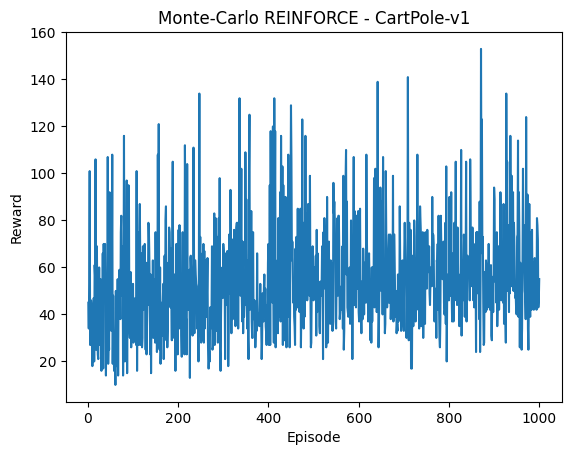

In [10]:
# Plot the learning curve
plt.plot(np.arange(1, num_episodes + 1), episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Monte-Carlo REINFORCE - CartPole-v1')
plt.show()

# New code


In [31]:
# Define hyperparameters
num_episodes = 1000
learning_rate_theta = 0.01
learning_rate_phi = 0.01
gamma = 0.99

In [32]:
# Initialize the policy parameters and value function parameters
theta = np.random.randn(4, 2)
phi = np.random.randn(4)


In [33]:
# Function to choose an action based on the state and policy
def get_action(state, theta):
    logits = np.dot(state, theta)
    probs = np.exp(logits) / np.sum(np.exp(logits))
    action = np.random.choice(env.action_space.n, p=probs)
    return action

In [24]:
def get_action(state, theta):
    logits = np.dot(state, theta)
    action = np.argmax(logits)
    return action

In [34]:
# Function to compute the gradient of the policy
def compute_policy_gradient(episode, theta, use_baseline=False):
    gradient = np.zeros_like(theta)
    for t, (state, action, reward, baseline) in enumerate(episode):
        logits = np.dot(state, theta)
        probs = np.exp(logits) / np.sum(np.exp(logits))
        if use_baseline:
            gradient[:, action] += state * (reward - baseline) * (1 - probs[action])
            gradient[:, 1 - action] -= state * (reward - baseline) * probs[1 - action]
        else:
            gradient[:, action] += state * (1 - probs[action])
            gradient[:, 1 - action] -= state * probs[1 - action]
    return gradient

In [35]:
# Function to compute the gradient of the value function (baseline)
def compute_baseline_gradient(episode, phi):
    gradient = np.zeros_like(phi)
    for t, (state, _, _, _) in enumerate(episode):
        gradient += (episode[t][2] - np.dot(state, phi)) * state
    return gradient

In [36]:
# Training loop
episode_rewards_without_baseline = []
episode_rewards_with_baseline = []

In [38]:
for episode in range(num_episodes):
    state = env.reset()
    episode_data = []
    done = False

    while not done:
        action = get_action(state, theta)
        next_state, reward, done, _ = env.step(action)
        baseline = np.dot(state, phi)
        episode_data.append((state, action, reward, baseline))
        state = next_state

    # Compute the return for each step
    episode_return = 0
    for t in range(len(episode_data) - 1, -1, -1):
        _, _, reward, _ = episode_data[t]
        episode_return = reward + gamma * episode_return
        episode_data[t] = (episode_data[t][0], episode_data[t][1], episode_return, episode_data[t][3])

    # Compute the gradients and update the parameters
    policy_gradient_without_baseline = compute_policy_gradient(episode_data, theta, use_baseline=False)
    policy_gradient_with_baseline = compute_policy_gradient(episode_data, theta, use_baseline=True)
    baseline_gradient = compute_baseline_gradient(episode_data, phi)




    theta += learning_rate_theta * policy_gradient_without_baseline
    theta += learning_rate_theta * policy_gradient_with_baseline
    phi += learning_rate_phi * baseline_gradient

    episode_rewards_without_baseline.append(len(episode_data))
    episode_rewards_with_baseline.append(len(episode_data))

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Average reward without baseline = {np.mean(episode_rewards_without_baseline[-100:])}")
        print(f"Episode {episode + 1}: Average reward with baseline = {np.mean(episode_rewards_with_baseline[-100:])}")


Episode 100: Average reward without baseline = 12.43
Episode 100: Average reward with baseline = 12.43
Episode 200: Average reward without baseline = 36.5
Episode 200: Average reward with baseline = 36.5
Episode 300: Average reward without baseline = 170.73
Episode 300: Average reward with baseline = 170.73
Episode 400: Average reward without baseline = 141.72
Episode 400: Average reward with baseline = 141.72
Episode 500: Average reward without baseline = 142.99
Episode 500: Average reward with baseline = 142.99
Episode 600: Average reward without baseline = 138.09
Episode 600: Average reward with baseline = 138.09
Episode 700: Average reward without baseline = 115.68
Episode 700: Average reward with baseline = 115.68
Episode 800: Average reward without baseline = 107.56
Episode 800: Average reward with baseline = 107.56
Episode 900: Average reward without baseline = 113.7
Episode 900: Average reward with baseline = 113.7
Episode 1000: Average reward without baseline = 128.39
Episode 

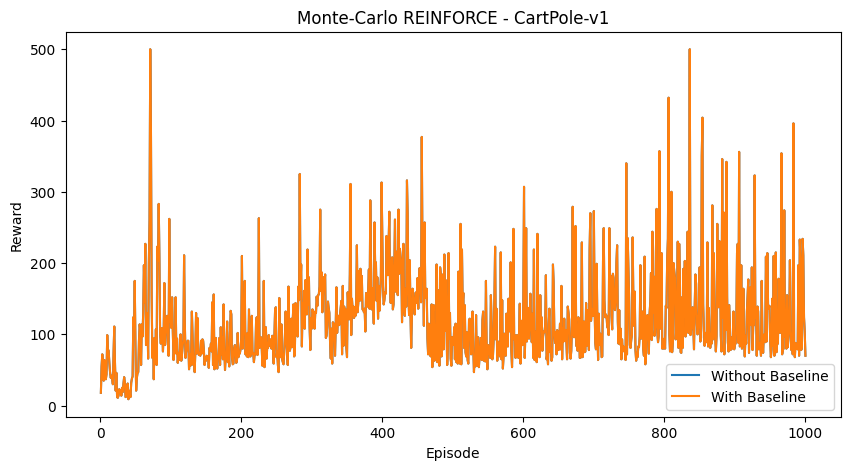

In [34]:
# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_episodes + 1), episode_rewards_without_baseline, label='Without Baseline')
plt.plot(np.arange(1, num_episodes + 1), episode_rewards_with_baseline, label='With Baseline')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Monte-Carlo REINFORCE - CartPole-v1')
plt.legend()
plt.show()

# Trial 3


In [ ]:
# Define hyperparameters
num_episodes = 500
learning_rate_theta = 0.05
learning_rate_phi = 0.01
gamma = 0.99

# Function to choose an action based on the state and policy
def get_action(state, theta):
    logits = np.dot(state, theta)
    probs = np.exp(logits) / np.sum(np.exp(logits))
    action = np.random.choice(env.action_space.n, p=probs)
    return action

# Function to compute the gradient of the policy
def compute_policy_gradient(episode, theta, use_baseline=False):
    gradient = np.zeros_like(theta)
    for t, (state, action, reward, baseline) in enumerate(episode):
        logits = np.dot(state, theta)
        probs = np.exp(logits) / np.sum(np.exp(logits))
        if use_baseline:
            gradient[:, action] += state * (reward - baseline) * (1 - probs[action])
            gradient[:, 1 - action] -= state * (reward - baseline) * probs[1 - action]
        else:
            gradient[:, action] += state * (1 - probs[action])
            gradient[:, 1 - action] -= state * probs[1 - action]
    return gradient

# Function to compute the gradient of the value function (baseline)
def compute_baseline_gradient(episode, phi):
    gradient = np.zeros_like(phi)
    for t, (state, _, _, _) in enumerate(episode):
        gradient += (episode[t][2] - np.dot(state, phi)) * state
    return gradient

# Training loop without baseline
episode_rewards_without_baseline = []
theta_without_baseline = np.random.randn(4, 2)

for episode in range(num_episodes):
    state = env.reset()
    episode_data = []
    done = False

    while not done:
        action = get_action(state, theta_without_baseline)
        next_state, reward, done, _= env.step(action)
        episode_data.append((state, action, reward, 0))
        state = next_state

    # Compute the return for each step
    episode_return = 0
    for t in range(len(episode_data) - 1, -1, -1):
        _, _, reward, _ = episode_data[t]
        episode_return = reward + gamma * episode_return
        episode_data[t] = (episode_data[t][0], episode_data[t][1], episode_return, episode_data[t][3])

    # Compute the gradient and update the parameters
    policy_gradient = compute_policy_gradient(episode_data, theta_without_baseline)
    theta_without_baseline += learning_rate_theta * policy_gradient

    episode_rewards_without_baseline.append(len(episode_data))

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Average reward without baseline = {np.mean(episode_rewards_without_baseline[-100:])}")

# Training loop with baseline
episode_rewards_with_baseline = []
theta_with_baseline = np.random.randn(4, 2)
phi = np.random.randn(4)

for episode in range(num_episodes):
    state = env.reset()
    episode_data = []
    done = False

    while not done:
        action = get_action(state, theta_with_baseline)
        next_state, reward, done, _ = env.step(action)
        baseline = np.dot(state, phi)
        episode_data.append((state, action, reward, baseline))
        state = next_state

    # Compute the return for each step
    episode_return = 0
    for t in range(len(episode_data) - 1, -1, -1):
        _, _, reward, _ = episode_data[t]
        episode_return = reward + gamma * episode_return
        episode_data[t] = (episode_data[t][0], episode_data[t][1], episode_return, episode_data[t][3])

    # Compute the gradients and update the parameters
    policy_gradient = compute_policy_gradient(episode_data, theta_with_baseline, use_baseline=True)
    baseline_gradient = compute_baseline_gradient(episode_data, phi)

    theta_with_baseline += learning_rate_theta * policy_gradient
    phi += learning_rate_phi * baseline_gradient

    episode_rewards_with_baseline.append(len(episode_data))

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Average reward with baseline = {np.mean(episode_rewards_with_baseline[-100:])}")
# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_episodes + 1), episode_rewards_without_baseline, label='Without Baseline')
plt.plot(np.arange(1, num_episodes + 1), episode_rewards_with_baseline, label='With Baseline')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Monte-Carlo REINFORCE - CartPole-v1')
plt.legend()
plt.show()

In [5]:

# Define hyperparameters
num_episodes = 500
learning_rate_theta = 0.05
learning_rate_phi = 0.01
gamma = 0.99


In [ ]:
def get_action(state, theta):
    logits = np.dot(state, theta)
    action = np.argmax(logits)
    return action

In [6]:
# Function to choose an action based on the state and policy
def get_action(state, theta):
    logits = np.dot(state, theta)
    probs = np.exp(logits) / np.sum(np.exp(logits))
    action = np.random.choice(env.action_space.n, p=probs)
    return action


In [7]:
# Function to compute the gradient of the policy
def compute_policy_gradient(episode, theta, use_baseline=False):
    gradient = np.zeros_like(theta)
    for t, (state, action, reward, baseline) in enumerate(episode):
        logits = np.dot(state, theta)
        probs = np.exp(logits) / np.sum(np.exp(logits))
        if use_baseline:
            gradient[:, action] += state * (reward - baseline) * (1 - probs[action])
            gradient[:, 1 - action] -= state * (reward - baseline) * probs[1 - action]
        else:
            gradient[:, action] += state * (1 - probs[action]) * reward
            gradient[:, 1 - action] -= state * probs[1 - action] * reward
    return gradient

In [8]:
# Function to compute the gradient of the value function (baseline)
def compute_baseline_gradient(episode, phi):
    gradient = np.zeros_like(phi)
    for t, (state, _, _, _) in enumerate(episode):
        gradient += (episode[t][2] - np.dot(state, phi)) * state
    return gradient


In [13]:
# Training loop without baseline
episode_rewards_without_baseline = []
theta_without_baseline = np.random.randn(4, 2)

for episode in range(num_episodes):
    state = env.reset()
    episode_data = []
    done = False

    while not done:
        action = get_action(state, theta_without_baseline)
        next_state, reward, done, _= env.step(action)
        episode_data.append((state, action, reward, 0))
        state = next_state

    # Compute the return for each step
    episode_return = 0
    for t in range(len(episode_data) - 1, -1, -1):
        _, _, reward, _ = episode_data[t]
        episode_return = reward + gamma * episode_return
        episode_data[t] = (episode_data[t][0], episode_data[t][1], episode_return, episode_data[t][3])

    # Compute the gradient and update the parameters
    policy_gradient = compute_policy_gradient(episode_data, theta_without_baseline)
    theta_without_baseline += learning_rate_theta * policy_gradient

    episode_rewards_without_baseline.append(len(episode_data))

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Average reward without baseline = {np.mean(episode_rewards_without_baseline[-100:])}")

Episode 100: Average reward without baseline = 57.75
Episode 200: Average reward without baseline = 10.5
Episode 300: Average reward without baseline = 125.37
Episode 400: Average reward without baseline = 146.36
Episode 500: Average reward without baseline = 140.99


In [11]:
# Training loop with baseline
episode_rewards_with_baseline = []
theta_with_baseline = np.random.randn(4, 2)
phi = np.random.randn(4)

for episode in range(num_episodes):
    state = env.reset()
    episode_data = []
    done = False

    while not done:
        action = get_action(state, theta_with_baseline)
        next_state, reward, done, _ = env.step(action)
        baseline = np.dot(state, phi)
        episode_data.append((state, action, reward, baseline))
        state = next_state

    # Compute the return for each step
    episode_return = 0
    for t in range(len(episode_data) - 1, -1, -1):
        _, _, reward, _ = episode_data[t]
        episode_return = reward + gamma * episode_return
        episode_data[t] = (episode_data[t][0], episode_data[t][1], episode_return, episode_data[t][3])

    # Compute the gradients and update the parameters
    policy_gradient = compute_policy_gradient(episode_data, theta_with_baseline, use_baseline=True)
    baseline_gradient = compute_baseline_gradient(episode_data, phi)

    theta_with_baseline += learning_rate_theta * policy_gradient
    phi += learning_rate_phi * baseline_gradient

    episode_rewards_with_baseline.append(len(episode_data))

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Average reward with baseline = {np.mean(episode_rewards_with_baseline[-100:])}")


Episode 100: Average reward with baseline = 15.17
Episode 200: Average reward with baseline = 30.32
Episode 300: Average reward with baseline = 27.96
Episode 400: Average reward with baseline = 148.42
Episode 500: Average reward with baseline = 156.21


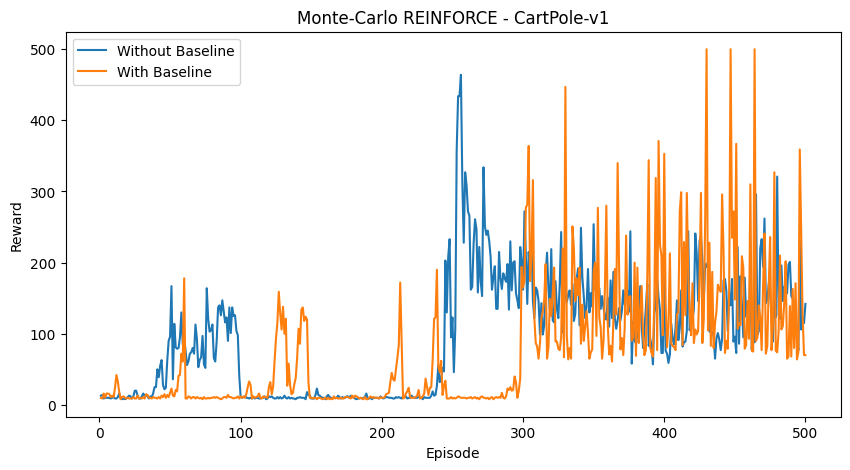

In [14]:
# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_episodes + 1), episode_rewards_without_baseline, label='Without Baseline')
plt.plot(np.arange(1, num_episodes + 1), episode_rewards_with_baseline, label='With Baseline')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Monte-Carlo REINFORCE - CartPole-v1')
plt.legend()
plt.show()

# 3rd april



In [2]:
import numpy as np
import gym

In [12]:
from scipy.special import softmax

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Create the CartPole environment
env = gym.make('CartPole-v1')



/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
# Define hyperparameters
num_episodes = 1000
learning_rate = 0.01
gamma = 0.99



In [5]:

# Initialize the policy parameters
theta = np.random.randn(4, 2)

In [15]:
# Function to choose an action based on the state and policy
def get_action1(state, theta):
    logits = np.dot(state, theta)
    logits -= np.max(logits)
    probs = np.exp(logits) / np.sum(np.exp(logits))
    action = np.random.choice(env.action_space.n, p=probs)
    return action

In [16]:
def get_action(state, theta):
    logits = np.dot(state, theta)
    probs = softmax(logits)
    action = np.random.choice(env.action_space.n, p=probs)
    return action

In [17]:
# Training loop
for episode in range(num_episodes):
    state = env.reset()
    episode_states = []
    episode_actions = []
    episode_rewards = []
    done = False

    while not done:
        action = get_action(state, theta)
        next_state, reward, done, _ = env.step(action)
        episode_states.append(state)
        episode_actions.append(action)
        episode_rewards.append(reward)
        state = next_state

    # Compute the return for each step
    episode_return = 0
    episode_returns = []
    for reward in reversed(episode_rewards):
        episode_return = reward + gamma * episode_return
        episode_returns.append(episode_return)
    episode_returns = episode_returns[::-1]

    # Compute the gradient and update the policy
    for t in range(len(episode_states)):
        state = episode_states[t]
        action = episode_actions[t]
        Gt = episode_returns[t]

        logits = np.dot(state, theta)

          # Subtract the maximum logit value for numerical stability

        probs = softmax(logits)

        grad_log_pi = np.zeros_like(theta)
        grad_log_pi[:, action] = state / probs[action]

        theta += learning_rate * gamma**t * Gt * grad_log_pi

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Average reward = {np.mean(episode_rewards)}")

ValueError: probabilities contain NaN

# 5th april


In [ ]:
# Define hyperparameters
num_episodes = 500
learning_rate_theta = 0.05
learning_rate_phi = 0.01
gamma = 0.99

# Function to choose an action based on the state and policy
def get_action(state, theta):
    logits = np.dot(state, theta)
    probs = np.exp(logits) / np.sum(np.exp(logits))
    action = np.random.choice(env.action_space.n, p=probs)
    return action

# Function to compute the gradient of the policy
def compute_policy_gradient(episode, theta, use_baseline=False):
    gradient = np.zeros_like(theta)
    for t, (state, action, reward, baseline) in enumerate(episode):
        logits = np.dot(state, theta)
        probs = np.exp(logits) / np.sum(np.exp(logits))
        if use_baseline:
            gradient[:, action] += state * (reward - baseline) * (1 - probs[action])
            gradient[:, 1 - action] -= state * (reward - baseline) * probs[1 - action]
        else:
            gradient[:, action] += state * (1 - probs[action])
            gradient[:, 1 - action] -= state * probs[1 - action]
    return gradient

# Function to compute the gradient of the value function (baseline)
def compute_baseline_gradient(episode, phi):
    gradient = np.zeros_like(phi)
    for t, (state, _, _, _) in enumerate(episode):
        gradient += (episode[t][2] - np.dot(state, phi)) * state
    return gradient

# Training loop without baseline
episode_rewards_without_baseline = []
theta_without_baseline = np.random.randn(4, 2)

for episode in range(num_episodes):
    state = env.reset()
    episode_data = []
    done = False

    while not done:
        action = get_action(state, theta_without_baseline)
        next_state, reward, done, _= env.step(action)
        episode_data.append((state, action, reward, 0))
        state = next_state

    # Compute the return for each step
    episode_return = 0
    for t in range(len(episode_data) - 1, -1, -1):
        _, _, reward, _ = episode_data[t]
        episode_return = reward + gamma * episode_return
        episode_data[t] = (episode_data[t][0], episode_data[t][1], episode_return, episode_data[t][3])

    # Compute the gradient and update the parameters
    policy_gradient = compute_policy_gradient(episode_data, theta_without_baseline)
    theta_without_baseline += learning_rate_theta * policy_gradient

    episode_rewards_without_baseline.append(len(episode_data))

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Average reward without baseline = {np.mean(episode_rewards_without_baseline[-100:])}")

# Training loop with baseline
episode_rewards_with_baseline = []
theta_with_baseline = np.random.randn(4, 2)
phi = np.random.randn(4)

for episode in range(num_episodes):
    state = env.reset()
    episode_data = []
    done = False

    while not done:
        action = get_action(state, theta_with_baseline)
        next_state, reward, done, _ = env.step(action)
        baseline = np.dot(state, phi)
        episode_data.append((state, action, reward, baseline))
        state = next_state

    # Compute the return for each step
    episode_return = 0
    for t in range(len(episode_data) - 1, -1, -1):
        _, _, reward, _ = episode_data[t]
        episode_return = reward + gamma * episode_return
        episode_data[t] = (episode_data[t][0], episode_data[t][1], episode_return, episode_data[t][3])

    # Compute the gradients and update the parameters
    policy_gradient = compute_policy_gradient(episode_data, theta_with_baseline, use_baseline=True)
    baseline_gradient = compute_baseline_gradient(episode_data, phi)

    theta_with_baseline += learning_rate_theta * policy_gradient
    phi += learning_rate_phi * baseline_gradient

    episode_rewards_with_baseline.append(len(episode_data))

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Average reward with baseline = {np.mean(episode_rewards_with_baseline[-100:])}")
# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_episodes + 1), episode_rewards_without_baseline, label='Without Baseline')
plt.plot(np.arange(1, num_episodes + 1), episode_rewards_with_baseline, label='With Baseline')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Monte-Carlo REINFORCE - CartPole-v1')
plt.legend()
plt.show()

In [3]:
# Define hyperparameters
num_episodes = 500
learning_rate_theta = 0.05
learning_rate_phi = 0.01
gamma = 0.99

In [4]:
# Function to choose an action based on the state and policy
def get_action(state, theta):
    logits = np.dot(state, theta)
    probs = np.exp(logits) / np.sum(np.exp(logits))
    action = np.random.choice(env.action_space.n, p=probs)
    return action

In [16]:
# Function to choose an action based on the state and policy
def get_action(state, theta):
    logits = np.dot(state, theta)
    probs = np.exp(logits) / np.sum(np.exp(logits))
    action = np.random.choice(env.action_space.n, p=probs)
    return action

# Function to compute the gradient of the policy
def compute_policy_gradient(episode, theta, use_baseline=False):
    gradient = np.zeros_like(theta)
    for t, (state, action, reward, baseline) in enumerate(episode):
        logits = np.dot(state, theta)
        probs = np.exp(logits) / np.sum(np.exp(logits))
        if use_baseline:
            gradient[:, action] += state * (reward - baseline) * (1 - probs[action])
            gradient[:, 1 - action] -= state * (reward - baseline) * probs[1 - action]
        else:
            gradient[:, action] += state * (1 - probs[action])*reward
            gradient[:, 1 - action] -= state * probs[1 - action]*reward
    return gradient

# Function to compute the gradient of the value function (baseline)
def compute_baseline_gradient(episode, phi):
    gradient = np.zeros_like(phi)
    for t, (state, _, _, _) in enumerate(episode):
        gradient += (episode[t][2] - np.dot(state, phi)) * state
    return gradient

In [ ]:
# # Training loop without baseline
# episode_rewards_without_baseline = []
# theta_without_baseline = np.random.randn(4, 2)

# for episode in range(num_episodes):
#     state = env.reset()
#     episode_data = []
#     done = False
#     G = 0  # Initialize G to 0

#     while not done:
#         action = get_action(state, theta_without_baseline)
#         next_state, reward, done, _ = env.step(action)
#         episode_data.append((state, action, reward))
#         state = next_state

#         # Update G for the current step
#         G = reward + gamma * G

#         # Compute the gradient and update the parameters for the current step
#         policy_gradient = compute_policy_gradient(state, action, G, theta_without_baseline)
#         theta_without_baseline += learning_rate_theta * policy_gradient

#     episode_rewards_without_baseline.append(len(episode_data))

#     if (episode + 1) % 100 == 0:
#         print(f"Episode {episode + 1}: Average reward without baseline = {np.mean(episode_rewards_without_baseline[-100:])}")

In [17]:
# Training loop without baseline
episode_rewards_without_baseline = []
theta_without_baseline = np.random.randn(4, 2)

for episode in range(num_episodes):
    state = env.reset()
    episode_data = []
    done = False

    while not done:
        action = get_action(state, theta_without_baseline)
        next_state, reward, done, _= env.step(action)
        episode_data.append((state, action, reward, 0))
        state = next_state

    # Compute the return for each step
    episode_return = 0
    for t in range(len(episode_data) - 1, -1, -1):
        _, _, reward, _ = episode_data[t]
        episode_return = reward + gamma * episode_return
        episode_data[t] = (episode_data[t][0], episode_data[t][1], episode_return, episode_data[t][3])

    gradient = np.zeros_like(theta_without_baseline)
    for t, (state, action, reward, baseline) in enumerate(episode_data):
        logits = np.dot(state, theta_without_baseline)
        probs = np.exp(logits) / np.sum(np.exp(logits))

        gradient[:, action] += state * (1 - probs[action])*reward
        gradient[:, 1 - action] -= state * probs[1 - action]*reward

        theta_without_baseline += learning_rate_theta * (gamma**t)*gradient





    episode_rewards_without_baseline.append(len(episode_data))

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Average reward without baseline = {np.mean(episode_rewards_without_baseline[-100:])}")



Episode 100: Average reward without baseline = 345.26
Episode 200: Average reward without baseline = 327.71
Episode 300: Average reward without baseline = 227.74
Episode 400: Average reward without baseline = 275.09
Episode 500: Average reward without baseline = 216.84


In [ ]:
# Training loop with baseline

episode_rewards_with_baseline = []
theta_with_baseline = np.random.randn(4, 2)
phi = np.random.randn(4)

for episode in range(num_episodes):
    state = env.reset()
    episode_data = []
    done = False

    while not done:
        action = get_action(state, theta_with_baseline)
        next_state, reward, done, _= env.step(action)
        baseline = np.dot(state, phi)
        episode_data.append((state, action, reward, baseline))
        state = next_state

    # Compute the return for each step
    episode_return = 0
    for t in range(len(episode_data) - 1, -1, -1):
        _, _, reward, _ = episode_data[t]
        episode_return = reward + gamma * episode_return
        episode_data[t] = (episode_data[t][0], episode_data[t][1], episode_return, episode_data[t][3])

    gradient = np.zeros_like(theta_with_baseline)
    baseline_gradient = np.zeros_like(phi)
    for t, (state, action, reward, baseline) in enumerate(episode_data):
        logits = np.dot(state, theta_with_baseline)
        probs = np.exp(logits) / np.sum(np.exp(logits))

        gradient[:, action] += state * (1 - probs[action])*(reward-baseline)
        gradient[:, 1 - action] -= state * probs[1 - action]*(reward-baseline)

        theta_with_baseline += learning_rate_theta * (gamma**t)*gradient
        baseline_gradient = (episode_data[t][2] - np.dot(state, phi)) * state
        phi += learning_rate_phi * baseline_gradient


    episode_rewards_without_baseline.append(len(episode_data))

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Average reward without baseline = {np.mean(episode_rewards_without_baseline[-100:])}")

In [ ]:
# Function to compute the gradient of the value function (baseline)
def compute_baseline_gradient(episode, phi):
    gradient = np.zeros_like(phi)
    for t, (state, _, _, _) in enumerate(episode):
        gradient += (episode[t][2] - np.dot(state, phi)) * state
    return gradient


In [20]:
# Training loop with baseline
episode_rewards_with_baseline = []
theta_with_baseline = np.random.randn(4, 2)
phi = np.random.randn(4)

for episode in range(num_episodes):
    state = env.reset()
    episode_data = []
    done = False

    while not done:
        action = get_action(state, theta_with_baseline)
        next_state, reward, done, _ = env.step(action)
        baseline = np.dot(state, phi)
        episode_data.append((state, action, reward, baseline))
        state = next_state

    # Initialize the return
    episode_return = 0

    # Loop for each step of the episode from 0 to T-1
    for t in range(len(episode_data)):
        state, action, reward, baseline = episode_data[t]
        episode_return = reward + gamma * episode_return

        logits = np.dot(state, theta_with_baseline)
        probs = np.exp(logits) / np.sum(np.exp(logits))

        # Compute the gradient for theta
        gradient = np.zeros_like(theta_with_baseline)
        gradient[:, action] += state * (1 - probs[action]) * (episode_return - np.dot(state, phi))
        gradient[:, 1 - action] -= state * probs[1 - action] * (episode_return - np.dot(state, phi))

        # Update theta
        theta_with_baseline += learning_rate_theta * gradient

        # Compute the gradient for phi (baseline)
        baseline_gradient = (episode_return - np.dot(state, phi)) * state

        # Update phi
        phi += learning_rate_phi * baseline_gradient

    episode_rewards_with_baseline.append(len(episode_data))

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Average reward with baseline = {np.mean(episode_rewards_with_baseline[-100:])}")

Episode 100: Average reward with baseline = 75.28
Episode 200: Average reward with baseline = 69.93
Episode 300: Average reward with baseline = 55.76
Episode 400: Average reward with baseline = 46.13
Episode 500: Average reward with baseline = 45.97
